# Simple Analysis
## Wave, no production in Belgium

In [1]:
from datetime import datetime

def is_leap_year(year):
    """Determine whether a year is a leap year."""
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def sum_hours_over_years(start_year, end_year):
    """Calculate the sum of hours from start_year to end_year, inclusive."""
    total_hours = 0
    for year in range(start_year, end_year + 1):
        if is_leap_year(year):
            total_hours += 366 * 24  # Leap year has 366 days
        else:
            total_hours += 365 * 24  # Non-leap year has 365 days
    return total_hours

# Now, we will iterate over the years from 2015 to 2019 as per the requirement.
start_year = 2015
end_year = 2019
yearly_hours = {}

# Calculating the sum of hours for each range starting from 2015
for year in range(start_year, end_year + 1):
    yearly_hours[f"{start_year}-{year}"] = sum_hours_over_years(start_year, year)

yearly_hours

{'2015-2015': 8760,
 '2015-2016': 17544,
 '2015-2017': 26304,
 '2015-2018': 35064,
 '2015-2019': 43824}

In [2]:
from gboml import GbomlGraph

timehorizon = 17544

# Initialize and build the model
gboml_model = GbomlGraph(timehorizon=timehorizon)
nodes, edges, param = gboml_model.import_all_nodes_and_edges("../../models/wave/greenland_wave.gboml")
gboml_model.add_global_parameters(param)
gboml_model.add_nodes_in_model(*nodes)
gboml_model.add_hyperedges_in_model(*edges)
gboml_model.build_model()

# Solve the model
solution, obj, status, solver_info, constr_info, _ = gboml_model.solve_gurobi(opt_file="gurobi.txt", details=True)

print("Solved")


Check variables of node LIQUEFIED_METHANE_CARRIERS_GR : --- 0.0015902519226074219 seconds ---
Check variables of node LIQUEFIED_METHANE_STORAGE_HUB_GR : --- 0.0 seconds ---
Check variables of node METHANE_LIQUEFACTION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node METHANATION_PLANTS_GR : --- 0.003385305404663086 seconds ---
Check variables of node WATER_STORAGE_GR : --- 0.001049041748046875 seconds ---
Check variables of node CARBON_DIOXIDE_STORAGE_GR : --- 0.0 seconds ---
Check variables of node HYDROGEN_STORAGE_GR : --- 0.0 seconds ---
Check variables of node DIRECT_AIR_CAPTURE_PLANTS_GR : --- 0.0 seconds ---
Check variables of node DESALINATION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node ELECTROLYSIS_PLANTS_GR : --- 0.0 seconds ---
Check variables of node HVDC_GR : --- 0.0 seconds ---
Check variables of node BATTERY_STORAGE_GR : --- 0.0025696754455566406 seconds ---
Check variables of node WAVE_PLANT_GR : --- 0.0 seconds ---
Check variables of node ENERGY_DEMAND

   12249 DPushes remaining with DInf 0.0000000e+00               101s
   10394 DPushes remaining with DInf 0.0000000e+00               106s
    8539 DPushes remaining with DInf 0.0000000e+00               111s
    7055 DPushes remaining with DInf 0.0000000e+00               115s
    5942 DPushes remaining with DInf 0.0000000e+00               122s
    5200 DPushes remaining with DInf 0.0000000e+00               127s
    4458 DPushes remaining with DInf 0.0000000e+00               133s
    4087 DPushes remaining with DInf 0.0000000e+00               135s
    3345 DPushes remaining with DInf 0.0000000e+00               141s
    2603 DPushes remaining with DInf 0.0000000e+00               146s
    1861 DPushes remaining with DInf 0.0000000e+00               152s
    1490 DPushes remaining with DInf 0.0000000e+00               155s
     748 DPushes remaining with DInf 0.0000000e+00               162s
     377 DPushes remaining with DInf 0.0000000e+00               165s
       0 DPushes rem

In [3]:
import json

gathered_data = gboml_model.turn_solution_to_dictionary(solver_info, status, solution, obj, constr_info)
print("Json done")
with open(f'../../models/wave/results/RREH.json', "w") as fp:json.dump(gathered_data, fp, indent=4)

Json done


In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class MakeMeReadable:
    def __init__(self, d):
        self.d = d
    
    def __dir__(self):
        return self.d.keys()
    
    def __getattr__(self, v):
        try:
            out = self.d[v]
            if isinstance(out, dict):
                return MakeMeReadable(out)
            return out
        except:
            return getattr(self.d, v)
        
    def __str__(self):
        return str(self.d)
    
    def __repr__(self):
        return repr(self.d)

In [6]:
dico = {}
with open('../../models/wave/results/RREH.json', 'r') as f:
    dico = json.load(f)
            
d = MakeMeReadable(dico)
    
if isinstance(dico, dict):
    print('The data is a dictionary')
else:
    print('The data is not a dictionary')

The data is a dictionary


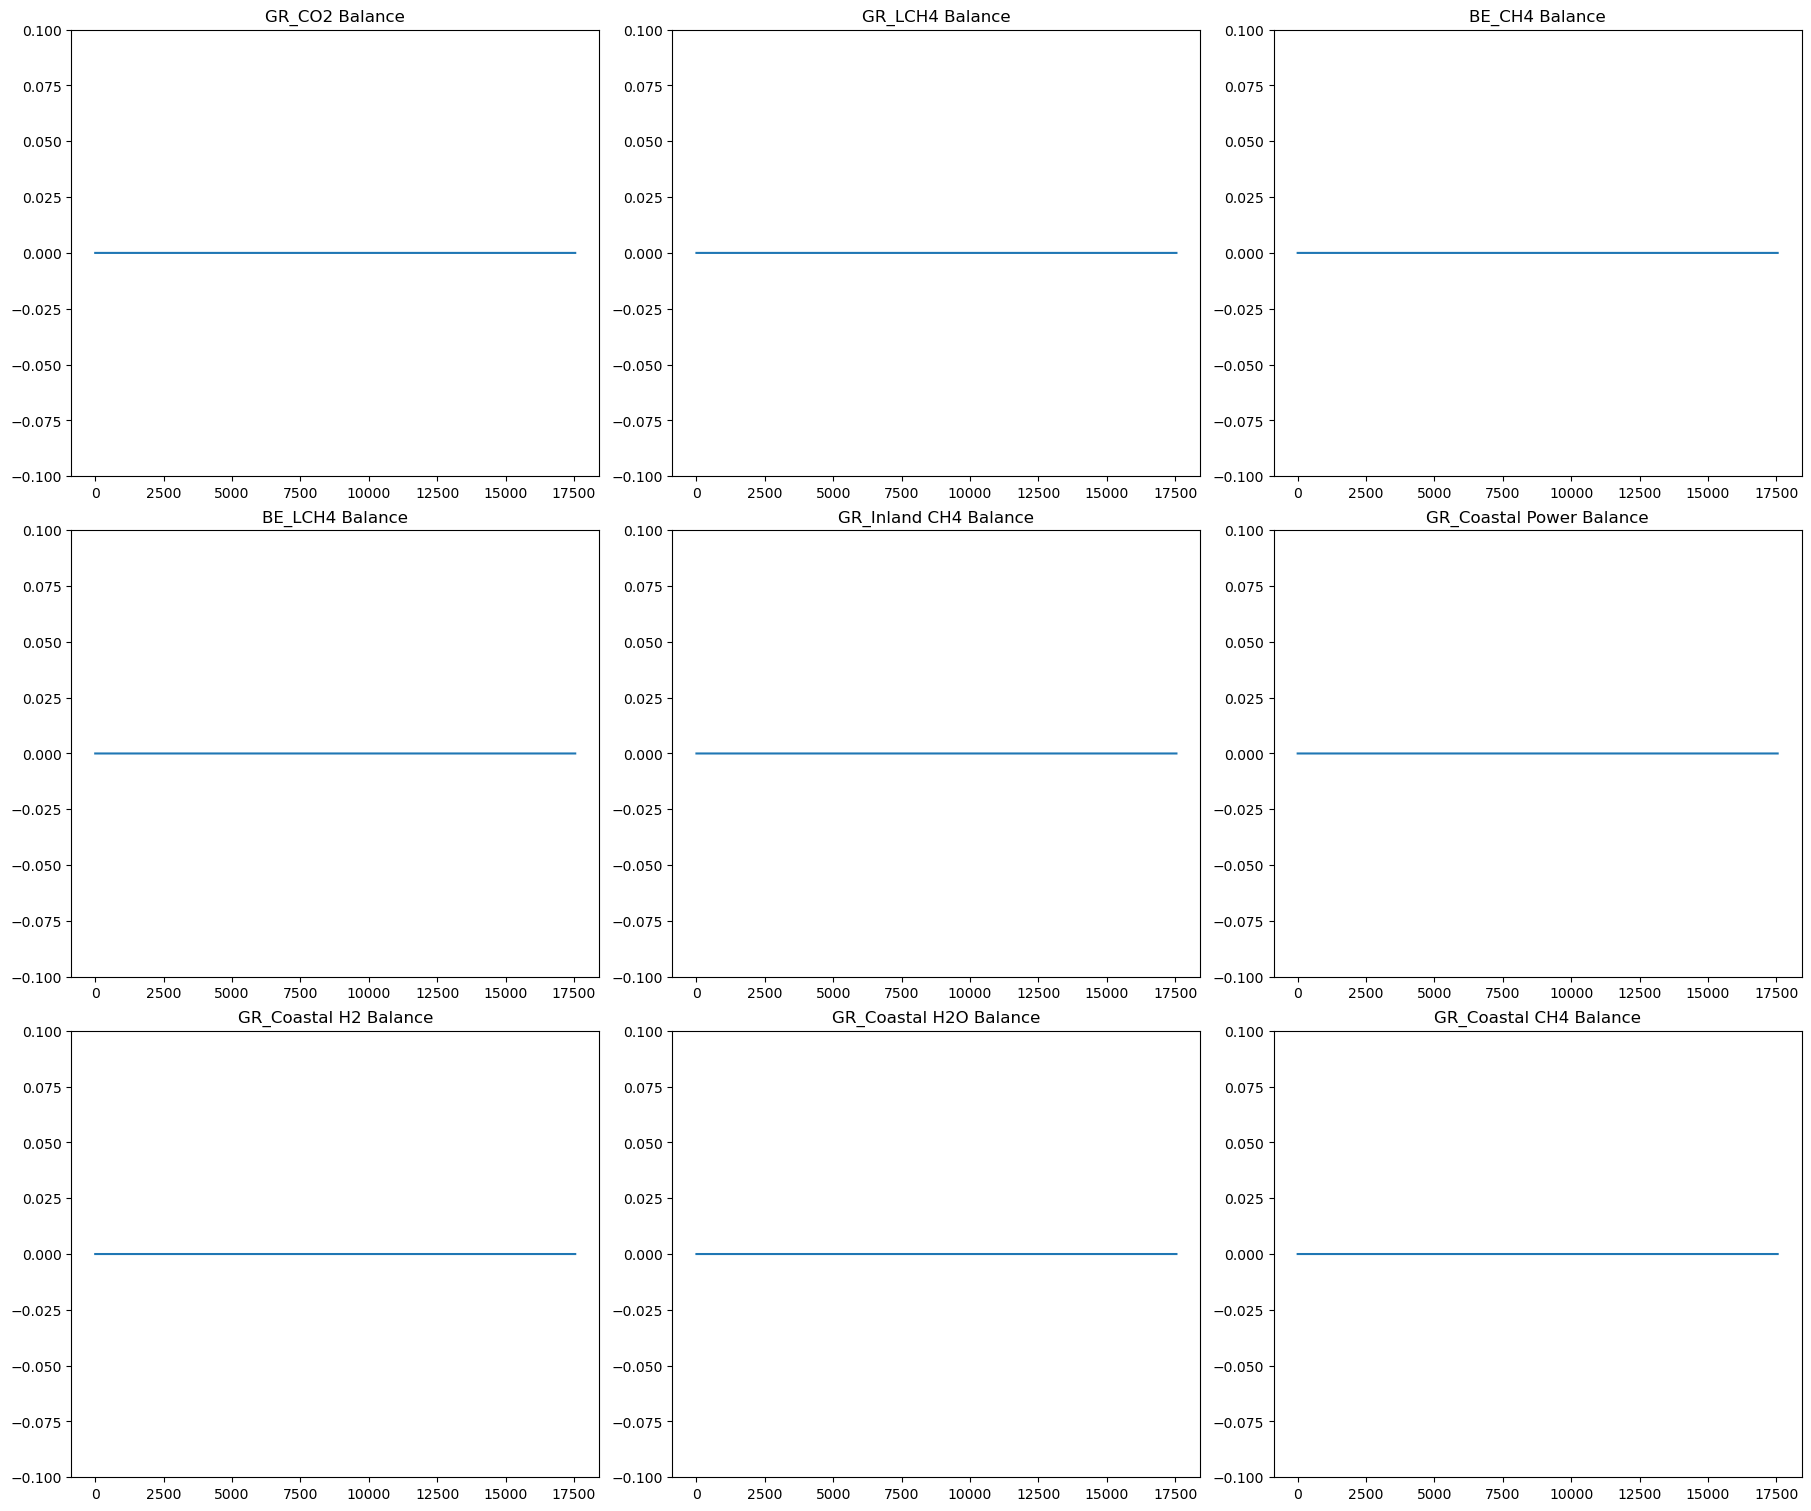

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 15), constrained_layout=True)
ylim = (-0.1, 0.1)
axs = axs.flatten()
def plot_balance(ax, data, title):
    ax.plot(data)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
# GR_CO2 Balance
co2_storage_gr_in = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_GR.variables.carbon_dioxide_in.values)
co2_storage_gr_out = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_GR.variables.carbon_dioxide_out.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.carbon_dioxide.values)
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.carbon_dioxide.values)
co2_balance_gr = dac_gr + co2_storage_gr_out - co2_storage_gr_in - methanation_gr

plot_balance(axs[0], co2_balance_gr, 'GR_CO2 Balance')

# GR_LCH4 Balance
lch4_carriers_gr = np.array(d.solution.elements.LIQUEFIED_METHANE_CARRIERS_GR.variables.liquefied_methane_in.values)
lch4_storage_gr_in = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_HUB_GR.variables.liquefied_methane_in.values)
lch4_storage_gr_out = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_HUB_GR.variables.liquefied_methane_out.values)
ch4_liquefaction_gr = np.array(d.solution.elements.METHANE_LIQUEFACTION_PLANTS_GR.variables.liquefied_methane.values)
lch4_balance_gr = ch4_liquefaction_gr + lch4_storage_gr_out - lch4_storage_gr_in - lch4_carriers_gr

plot_balance(axs[1], lch4_balance_gr, 'GR_LCH4 Balance')

# Check BE_CH4 Balance
conversion_factor = d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.conversion_factor
demand_CH4 = np.array(d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.demand)
lch4_regasification_be = np.array(d.solution.elements.LIQUEFIED_METHANE_REGASIFICATION.variables.methane.values)
ch4_balance_be = conversion_factor * lch4_regasification_be - 10 * demand_CH4[:timehorizon]

plot_balance(axs[2], ch4_balance_be, 'BE_CH4 Balance')


# Check BE_LCH4 Balance
lch4_carriers_gr = np.array(d.solution.elements.LIQUEFIED_METHANE_CARRIERS_GR.variables.liquefied_methane_out.values)
lch4_storage_dest_in = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_DESTINATION.variables.liquefied_methane_in.values)
lch4_storage_dest_out = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_DESTINATION.variables.liquefied_methane_out.values)
lch4_regasification_be = np.array(d.solution.elements.LIQUEFIED_METHANE_REGASIFICATION.variables.liquefied_methane.values)
lch4_balance_be = lch4_carriers_gr + lch4_storage_dest_out - lch4_storage_dest_in - lch4_regasification_be

plot_balance(axs[3], lch4_balance_be, 'BE_LCH4 Balance')


# Check GR_INLAND CH4 Balance
battery_storage_gr_out = np.array(d.solution.elements.BATTERY_STORAGE_GR.variables.electricity_out.values)
battery_storage_gr_in = np.array(d.solution.elements.BATTERY_STORAGE_GR.variables.electricity_in.values)
hvdc_gr_in = np.array(d.solution.elements.HVDC_GR.variables.electricity_in.values)
wave_gr = np.array(d.solution.elements.WAVE_PLANT_GR.variables.electricity.values)

power_balance_gr = wave_gr + battery_storage_gr_out - battery_storage_gr_in - hvdc_gr_in

plot_balance(axs[4], power_balance_gr, 'GR_Inland CH4 Balance')


# Check GR_Coastal Power Balance
hvdc_gr_out = np.array(d.solution.elements.HVDC_GR.variables.electricity_out.values)
electrolysis_gr = np.array(d.solution.elements.ELECTROLYSIS_PLANTS_GR.variables.electricity.values)
h2_storage_gr = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.electricity.values)
desalination_gr = np.array(d.solution.elements.DESALINATION_PLANTS_GR.variables.electricity.values)
h2o_storage_gr = np.array(d.solution.elements.WATER_STORAGE_GR.variables.electricity.values)
co2_storage_gr = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_GR.variables.electricity.values)
ch4_liquefaction_gr = np.array(d.solution.elements.METHANE_LIQUEFACTION_PLANTS_GR.variables.electricity.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.electricity.values)
power_balance_gr = hvdc_gr_out - electrolysis_gr - h2_storage_gr - desalination_gr - h2o_storage_gr - co2_storage_gr - ch4_liquefaction_gr - dac_gr 

plot_balance(axs[5], power_balance_gr, 'GR_Coastal Power Balance')


# Check GR_Coastal H2 Balance
electrolysis_gr = np.array(d.solution.elements.ELECTROLYSIS_PLANTS_GR.variables.hydrogen.values)
h2_storage_gr_out = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.hydrogen_out.values)
h2_storage_gr_in = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.hydrogen_in.values)
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.hydrogen.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.hydrogen.values)
h2_balance_gr = electrolysis_gr + h2_storage_gr_out - h2_storage_gr_in - methanation_gr - dac_gr

plot_balance(axs[6], h2_balance_gr, 'GR_Coastal H2 Balance')


# Check GR_Coastal H2O Balance
desalination_gr = np.array(d.solution.elements.DESALINATION_PLANTS_GR.variables.water.values)
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.water.values)
h2o_storage_gr_out = np.array(d.solution.elements.WATER_STORAGE_GR.variables.water_out.values)
h2o_storage_gr_in = np.array(d.solution.elements.WATER_STORAGE_GR.variables.water_in.values)
electrolysis_gr = np.array(d.solution.elements.ELECTROLYSIS_PLANTS_GR.variables.water.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.water.values)
h20_balance_gr = desalination_gr + methanation_gr + h2o_storage_gr_out - h2o_storage_gr_in - electrolysis_gr - dac_gr

plot_balance(axs[7], h20_balance_gr, 'GR_Coastal H2O Balance')

# Check GR_Coastal CH4 Balance
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.methane.values)
ch4_liquefaction_gr = np.array(d.solution.elements.METHANE_LIQUEFACTION_PLANTS_GR.variables.liquefied_methane.values)
ch4_balance_gr = methanation_gr - ch4_liquefaction_gr

plot_balance(axs[8], ch4_balance_gr, 'GR_Coastal CH4 Balance')

plt.show()

print()

In [8]:
ls_nodes = list(d.model.nodes.keys())

print(ls_nodes)

['LIQUEFIED_METHANE_CARRIERS_GR', 'LIQUEFIED_METHANE_STORAGE_HUB_GR', 'METHANE_LIQUEFACTION_PLANTS_GR', 'METHANATION_PLANTS_GR', 'WATER_STORAGE_GR', 'CARBON_DIOXIDE_STORAGE_GR', 'HYDROGEN_STORAGE_GR', 'DIRECT_AIR_CAPTURE_PLANTS_GR', 'DESALINATION_PLANTS_GR', 'ELECTROLYSIS_PLANTS_GR', 'HVDC_GR', 'BATTERY_STORAGE_GR', 'WAVE_PLANT_GR', 'ENERGY_DEMAND_BE', 'LIQUEFIED_METHANE_STORAGE_DESTINATION', 'LIQUEFIED_METHANE_REGASIFICATION']


In [9]:
def cost_rreh(ls:list):
    if len(ls) == 0:
        return 0.0

    cost = 0

    for ele in ls:
        # print(f"{ele = }")
        # print(dico["solution"]["elements"][ele]["objectives"])
        try:
            cost += np.sum(dico["solution"]["elements"][ele]["objectives"]["unnamed"])
        except:
            for e in dico["solution"]["elements"][ele]["objectives"]["named"].values():
                # print(f"{e = }")
                cost += e
        # print(f"{cost = }")
    
    return cost

In [10]:
import re 

excluded_hydro_basins = [node for node in ls_nodes if re.match(r'HYDRO_BASIN_[\w]+_GR$', node)]

try:
    GR_nodes = [node for node in ls_nodes if node.endswith("_GR") and node not in excluded_hydro_basins]
except:
    GR_nodes = []
BE_nodes = list(map(lambda string: string if string[-3:] == "_BE" or string in ["PCCC_CCGT", "PCCC", "CO2_EXPORT", "LIQUEFIED_METHANE_STORAGE_DESTINATION","LIQUEFIED_METHANE_REGASIFICATION"] else None, ls_nodes))

try:
    GR_nodes = list(filter(lambda x: x not in [None, "PCCC", "PROD_CO2", "CO2_EXPORT"], GR_nodes))
except:
    GR_nodes = []
BE_nodes = list(filter(lambda x: x not in [None, "PROD_CO2"], BE_nodes))

cost_GR = cost_rreh(GR_nodes)
cost_BE = cost_rreh(BE_nodes)


print(f"GR {cost_GR = }")
print(f"BE {cost_BE = }")


obj_cost = d.solution.objective
tot_cost = np.sum([cost_GR, cost_BE])

abs_diff = np.abs(d.solution.objective - np.sum([cost_GR, cost_BE]))
print(f"{obj_cost = }")
print(f"{tot_cost = }")
print(abs_diff < 0.1)

GR cost_GR = 2537.0635664155834
BE cost_BE = 18.027522389570443
obj_cost = 2555.09108880666
tot_cost = 2555.091088805154
True


In [11]:
# Initialize a dictionary to hold individual capacities
plant_capacities = {}

wave_n_units = d.solution.elements.WAVE_PLANT_GR.variables.num_units.values[0]
wave_RP = d.model.nodes.WAVE_PLANT_GR.parameters.unit_rated_power[0]
plant_capacities['wave_off_gr'] = wave_RP * wave_n_units

# Compute the total installed capacity by summing all individual capacities
total_installed_capacity = sum(plant_capacities.values())

Installed capacity of wave = 2.779 GW

Total installed capacity = 2.779 GW


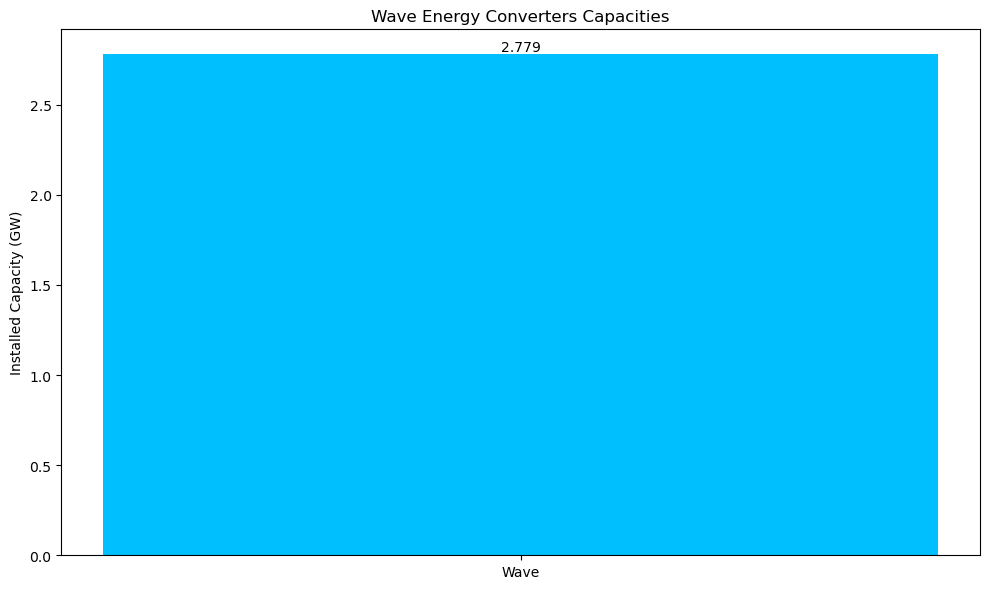

In [12]:
# Doesn't install on/offshore wind turbines if 1,7GW of Hydro

import matplotlib.pyplot as plt
import numpy as np

# Print installed capacities
for plant, capacity in plant_capacities.items():
    plant_type = "hydro" if "HYDRO_PLANT" in plant else "onshore" if "onshore" in plant else "offshore" if "wind_off" in plant else "wave"
    print(f"Installed capacity of {plant_type} = {capacity:.3f} GW")

# Calculate the total installed capacity
total_installed_capacity = sum(plant_capacities.values())

print(f"\nTotal installed capacity = {total_installed_capacity:.3f} GW")

# Calculate total hydro capacity by summing all hydro plant capacities
total_hydro_capacity = sum(capacity for plant, capacity in plant_capacities.items() if "HYDRO_PLANT" in plant)

# Data for the first plot
categories = [ 'Wave']
capacities = [
    plant_capacities.get('wave_off_gr', 0),
]

### Plot 1: Combined Wind and Total Hydro Capacities
plt.figure(figsize=(10, 6))
plt.bar(categories, capacities, color='deepskyblue')
plt.ylabel('Installed Capacity (GW)')
plt.title('Wave Energy Converters Capacities')
# Annotate each bar with its capacity
for i, v in enumerate(capacities):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [13]:
gas_demand = d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.demand
gas_demand = np.sum(gas_demand[:timehorizon])/1000
print("the gas demand is ", gas_demand, "TWh")

the gas demand is  1.2970272171668917 TWh


In [14]:
# LCH4 full production:
gas = np.array(d.solution.elements.LIQUEFIED_METHANE_REGASIFICATION.variables.methane.values) * 15.31 # kt/h * GWh/kt
gas_prod = np.sum(gas) # GWh
gas_prod/1000

12.970272171668919

In [15]:
demand_in_mwh = gas_prod * 1e3  # Convert TWh to MWh
total_cost_in_euros = tot_cost * 1e6  # Convert million euros to euros

# Compute price per MWh in euros
price_per_mwh = total_cost_in_euros / demand_in_mwh

print(f"The price is {round(price_per_mwh, 3)} €/MWh \n")
print("In February 2024, the natural gas price is between 40.2 and 51.5 €/MWh")  # Adjusted to €/MWh
print("This system is about", round((price_per_mwh / 45), 3), "times more expensive compared to a reference price of 45 €/MWh")

The price is 196.996 €/MWh 

In February 2024, the natural gas price is between 40.2 and 51.5 €/MWh
This system is about 4.378 times more expensive compared to a reference price of 45 €/MWh


In [16]:
def cost_rreh_detailed(ls):
    detailed_cost = {}
    if len(ls) == 0:
        return detailed_cost

    for ele in ls:
        node_cost = 0
        try:
            node_cost += np.sum(dico["solution"]["elements"][ele]["objectives"]["unnamed"])
        except:
            for e in dico["solution"]["elements"][ele]["objectives"]["named"].values():
                node_cost += e
        detailed_cost[ele] = node_cost
    
    return detailed_cost


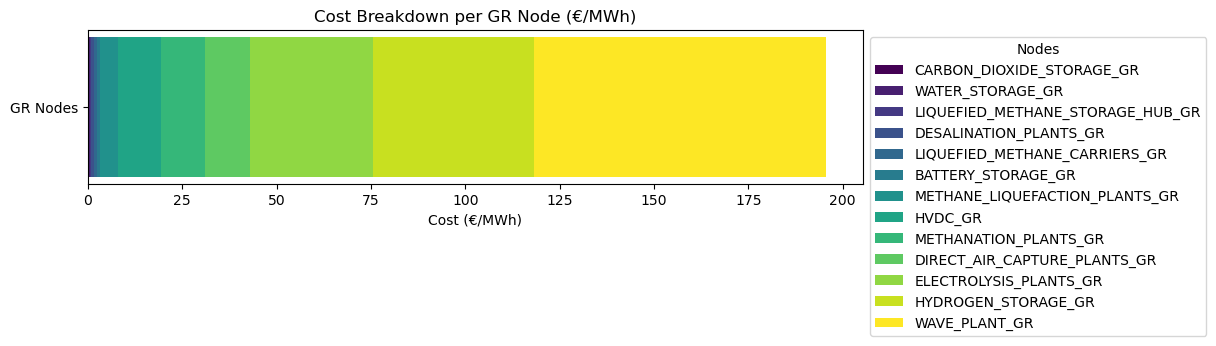

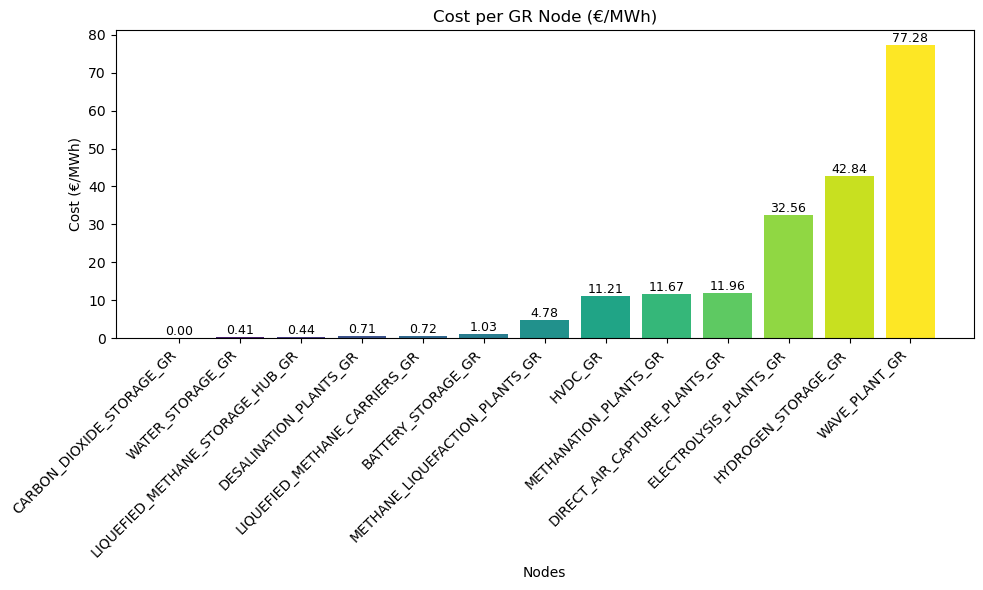

In [17]:
import matplotlib.pyplot as plt
import numpy as np

cost_details_GR = cost_rreh_detailed(GR_nodes)

sorted_nodes_and_costs = sorted(cost_details_GR.items(), key=lambda item: item[1])
sorted_nodes = [item[0] for item in sorted_nodes_and_costs]
sorted_costs = [item[1] for item in sorted_nodes_and_costs]

# Convert costs to €/MWh
adjusted_costs = [cost *1e6 / demand_in_mwh for cost in sorted_costs]

# Generate colors - ensuring consistent colors across plots
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_nodes)))

# Plot 1: Stacked Horizontal Bar Chart
plt.figure(figsize=(10, 2))
cumulative_cost = 0  # Start at 0 for the leftmost bar segment

for node, cost, color in zip(sorted_nodes, adjusted_costs, colors):
    plt.barh('GR Nodes', cost, left=cumulative_cost, color=color, label=node)
    cumulative_cost += cost

plt.xlabel('Cost (€/MWh)')
plt.title('Cost Breakdown per GR Node (€/MWh)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Nodes')
plt.show()

# Plot 2: Vertical Bar Chart with Sorted Nodes
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_nodes, adjusted_costs, color=colors)

plt.xlabel('Nodes')
plt.ylabel('Cost (€/MWh)')
plt.title('Cost per GR Node (€/MWh)')
plt.xticks(rotation=45, ha="right")

# Adding the cost above each bar
for bar, cost in zip(bars, adjusted_costs):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{cost:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_wave_production_dynamics(wave_prod_gr, start_date='2015-01-01'):
    # Create date range for the dataset
    date_range = pd.date_range(start=start_date, periods=len(wave_prod_gr), freq='H')

    # Create DataFrame for wave production
    wave_prod_df_gr = pd.DataFrame(wave_prod_gr, index=date_range, columns=['Elec'])
   
    # Smooth the data with a rolling mean
    wave_prod_df_gr['Smoothed'] = wave_prod_df_gr['Elec'].rolling(window=24).mean()
   
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.fill_between(wave_prod_df_gr.index, wave_prod_df_gr['Smoothed'], color='mediumblue', alpha=0.5)
    plt.title('Wave Energy Production Dynamics (Greenland)', fontsize=14, loc='left')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
    plt.ylabel('GWh')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

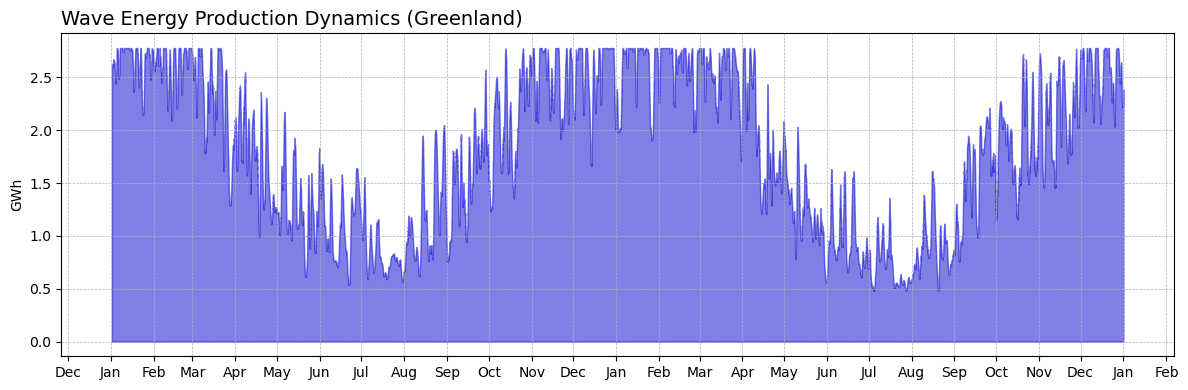

In [19]:
wave_prod_gr = np.array(d.solution.elements.WAVE_PLANT_GR.variables.electricity.values)

plot_wave_production_dynamics(wave_prod_gr)

In [20]:
import pandas as pd

# Example input data
# If the CSV has no header row, set header=None and provide column names
column_name = ['WaveEnergyDensity']
wave_energy_df = pd.read_csv('../../data/wave_series_goff.csv', header=None, names=column_name)

length_of_installation = d.solution.elements.WAVE_PLANT_GR.variables.length.values[0]
unit_width = d.model.nodes.WAVE_PLANT_GR.parameters.unit_width[0]  # meters
space_between = d.model.nodes.WAVE_PLANT_GR.parameters.space_between[0]  # meters

# Calculate total space required per unit (width + space)
total_space_per_unit = unit_width + space_between

# Calculate the number of units that can be installed
number_of_units = length_of_installation // total_space_per_unit

# Calculate the total energy potential for each wave energy density value
wave_energy_df['TotalEnergyPotentialGW'] = wave_energy_df['WaveEnergyDensity'] * wave_n_units * unit_width

# Calculate the total rated energy capacity based on the number of units
total_rated_capacity_gw = number_of_units * wave_RP

# Check when the total energy potential exceeds the total rated capacity
wave_energy_df['ExceedsRatedPower'] = wave_energy_df['TotalEnergyPotentialGW'] > total_rated_capacity_gw

print(wave_energy_df)

       WaveEnergyDensity  TotalEnergyPotentialGW  ExceedsRatedPower
0               0.000022                2.741608              False
1               0.000049                5.991109               True
2               0.000049                6.022928               True
3               0.000019                2.301037              False
4               0.000050                6.069551               True
...                  ...                     ...                ...
43817           0.000047                5.749049               True
43818           0.000027                3.296851               True
43819           0.000047                5.750780               True
43820           0.000047                5.750504               True
43821           0.000026                3.209169               True

[43822 rows x 3 columns]


C:\Users\gille\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


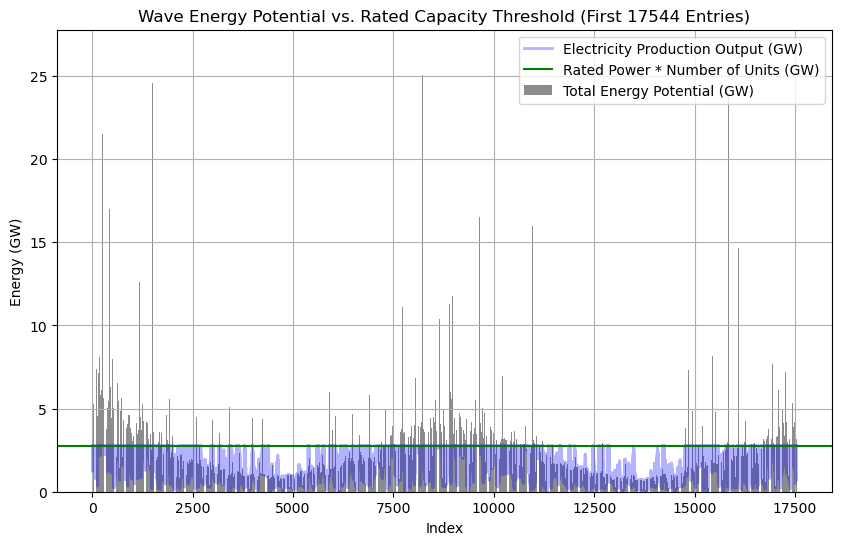

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Slice the DataFrame to only include the first x rows
wave_energy_df_subset = wave_energy_df.head(timehorizon)

# Convert wave_prod array/list to a pandas Series for easy plotting (match the length of the DataFrame subset)
wave_prod = pd.Series(wave_prod_gr[:timehorizon])

# For visualization, calculate the total rated capacity again for the plot
total_rated_capacity_gw = number_of_units * wave_RP

# Plotting
plt.figure(figsize=(10, 6))

# Plot Total Energy Potential GW for the subset as grey bars with 90% transparency
plt.bar(wave_energy_df_subset.index, wave_energy_df_subset['TotalEnergyPotentialGW'], color='grey', alpha=0.9, label='Total Energy Potential (GW)')

# Plot the electricity production output as a grey line with 90% transparency
plt.plot(wave_energy_df_subset.index, wave_prod, color='blue', markersize=3, label='Electricity Production Output (GW)', alpha=0.3, linewidth=2)

# Plot a line for the Total Rated Capacity GW Threshold
plt.axhline(y=total_rated_capacity_gw, color='green', linestyle='-', label='Rated Power * Number of Units (GW)')

# Set the y-axis limit to 10 times the total rated capacity
plt.ylim(0, 10 * total_rated_capacity_gw)

plt.xlabel('Index')
plt.ylabel('Energy (GW)')
plt.title('Wave Energy Potential vs. Rated Capacity Threshold (First {} Entries)'.format(timehorizon))
plt.legend()
plt.grid(True)

plt.show()

In [22]:
n=0
x=0
g=0
for t in range(len(wave_energy_df_subset)):
    calculated_prod = min(wave_energy_df_subset['WaveEnergyDensity'][t] * wave_n_units * unit_width, wave_RP * wave_n_units)
    if calculated_prod < wave_prod[t]:
        if 1.0001*calculated_prod< wave_prod[t]:
            n+=1
        print(f"Overprod at time {t}: Expected {round(calculated_prod,4)}, in Model {round(wave_prod[t],4)}")
    elif calculated_prod > wave_prod[t]: 
        if calculated_prod> 1.0001*wave_prod[t]:
            x+=1
        print(f"Underprod at time {t}: Expected {round(calculated_prod,4)}, in Model {round(wave_prod[t],4)}")
    elif calculated_prod == wave_prod[t]:
        g+=1
        print(f"Exactprod at time {t}: Expected {round(calculated_prod,4)}, in Model {round(wave_prod[t],4)}")

Underprod at time 0: Expected 2.7416, in Model 2.7416
Exactprod at time 1: Expected 2.7789, in Model 2.7789
Exactprod at time 2: Expected 2.7789, in Model 2.7789
Overprod at time 3: Expected 2.301, in Model 2.301
Exactprod at time 4: Expected 2.7789, in Model 2.7789
Exactprod at time 5: Expected 2.7789, in Model 2.7789
Underprod at time 6: Expected 1.9685, in Model 1.9685
Exactprod at time 7: Expected 2.7789, in Model 2.7789
Exactprod at time 8: Expected 2.7789, in Model 2.7789
Exactprod at time 9: Expected 1.2282, in Model 1.2282
Exactprod at time 10: Expected 2.7789, in Model 2.7789
Exactprod at time 11: Expected 2.7789, in Model 2.7789
Exactprod at time 12: Expected 2.7789, in Model 2.7789
Exactprod at time 13: Expected 2.7789, in Model 2.7789
Exactprod at time 14: Expected 2.7789, in Model 2.7789
Underprod at time 15: Expected 2.0558, in Model 2.0558
Exactprod at time 16: Expected 2.7789, in Model 2.7789
Exactprod at time 17: Expected 2.7789, in Model 2.7789
Exactprod at time 18: E

Overprod at time 13238: Expected 0.9061, in Model 0.9061
Overprod at time 13239: Expected 0.3099, in Model 0.3099
Exactprod at time 13240: Expected 0.9194, in Model 0.9194
Underprod at time 13241: Expected 0.9255, in Model 0.9255
Exactprod at time 13242: Expected 0.2688, in Model 0.2688
Underprod at time 13243: Expected 0.9363, in Model 0.9363
Underprod at time 13244: Expected 0.941, in Model 0.941
Exactprod at time 13245: Expected 0.2592, in Model 0.2592
Overprod at time 13246: Expected 0.9489, in Model 0.9489
Exactprod at time 13247: Expected 0.9521, in Model 0.9521
Underprod at time 13248: Expected 0.4644, in Model 0.4644
Exactprod at time 13249: Expected 0.9571, in Model 0.9571
Underprod at time 13250: Expected 0.9588, in Model 0.9588
Underprod at time 13251: Expected 0.7346, in Model 0.7346
Exactprod at time 13252: Expected 0.961, in Model 0.961
Underprod at time 13253: Expected 0.9615, in Model 0.9615
Overprod at time 13254: Expected 0.8954, in Model 0.8954
Exactprod at time 1325

In [23]:
print(n)
print(x)
print(g)

0
0
13550


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_storage_dynamics(battery_data, hydrogen_data, methane_data_src, methane_data_dest, start_date='2015-01-01'):
    # Create date range for the datasets
    date_range = pd.date_range(start=start_date, periods=len(battery_data), freq='H')

    # Create DataFrames
    battery_df = pd.DataFrame(battery_data, index=date_range, columns=['Battery'])
    hydrogen_df = pd.DataFrame(hydrogen_data, index=date_range, columns=['Hydrogen'])
    methane_df_gr = pd.DataFrame(methane_data_src, index=date_range, columns=['Methane'])
    methane_df_be = pd.DataFrame(methane_data_dest, index=date_range, columns=['Methane'])


    # Smooth the data with a rolling mean
    battery_df['Smoothed'] = battery_df['Battery'].rolling(window=24).mean()
    hydrogen_df['Smoothed'] = hydrogen_df['Hydrogen'].rolling(window=24).mean()
    methane_df_gr['Smoothed'] = methane_df_gr['Methane'].rolling(window=24).mean()
    methane_df_be['Smoothed'] = methane_df_be['Methane'].rolling(window=24).mean()

    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    colors = plt.cm.viridis(np.linspace(0, 1, 4))

    # Plot each storage type
    for ax, df, color, label in zip(axs,
                                    [battery_df, hydrogen_df, methane_df_gr, methane_df_be],
                                    colors,
                                    ['Battery Storage Dynamics', 'Hydrogen Storage Dynamics', 'Liquid Methane Storage Dynamics (Greenland)', 'Liquid Methane Storage Dynamics (Belgium)']):
        ax.fill_between(df.index, df['Smoothed'], color=color)
        ax.set_title(label, fontsize=10, loc='left')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.set_ylabel('GWh')

    # Adjust layout and show plot
    fig.tight_layout()
    plt.show()

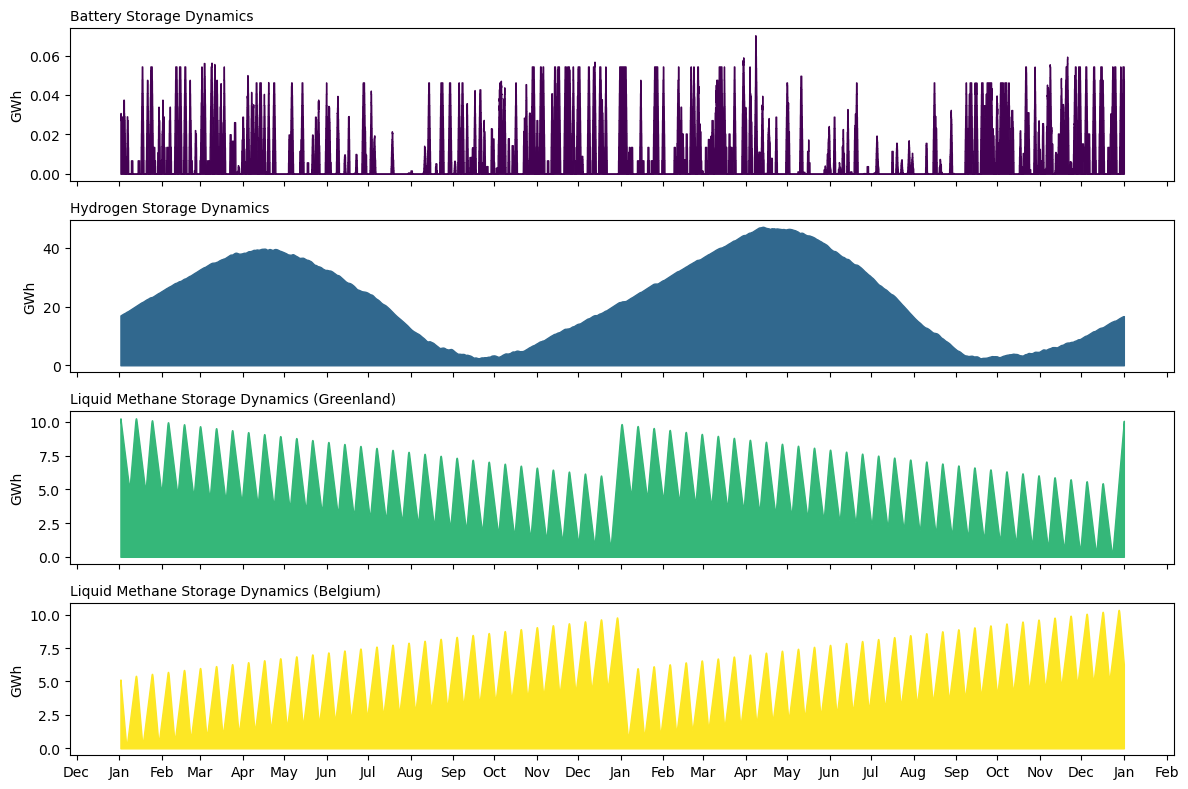

0.0
16.867408092726073
10.657891138972266
5.715802232037658


In [25]:
battery_flow = np.array(d.solution.elements.BATTERY_STORAGE_GR.variables.electricity_stored.values)
h2_flow = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.hydrogen_stored.values)
lch4_flow_gr = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_HUB_GR.variables.liquefied_methane_stored.values)
lch4_flow_be = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_DESTINATION.variables.liquefied_methane_stored.values)

plot_storage_dynamics(battery_flow, h2_flow, lch4_flow_gr, lch4_flow_be)

print(battery_flow[-1])
print(h2_flow[-1])
print(lch4_flow_gr[-1])
print(lch4_flow_be[-1])

In [26]:
leftover_lch4 = (lch4_flow_be[-1] + lch4_flow_gr[-1]) * 0.98 * 15.31 *1e3

leftover_lch4 # MWh

245667.6205999587

In [27]:
demand_in_mwh = gas_prod * 1e3  # Convert TWh to MWh
total_cost_in_euros = tot_cost * 1e6  # Convert million euros to euros

# Compute price per MWh in euros
new_price_per_mwh = total_cost_in_euros / (demand_in_mwh+leftover_lch4)

print(f"The price is {round(new_price_per_mwh, 3)} €/MWh \n")
print("In February 2024, the natural gas price is between 40.2 and 51.5 €/MWh")  # Adjusted to €/MWh
print("This system is about", round((new_price_per_mwh / 45), 3), "times more expensive compared to a reference price of 45 €/MWh")

The price is 193.334 €/MWh 

In February 2024, the natural gas price is between 40.2 and 51.5 €/MWh
This system is about 4.296 times more expensive compared to a reference price of 45 €/MWh


In [28]:
import calendar

def energy_demand():
    def daily_sum(ts):
        elec = np.array(ts[0])
        elec = elec.reshape((elec.shape[0]//24, 24))
        sum_elec = np.sum(elec, axis=1)
        
        return sum_elec

    df_elec = pd.read_csv("../../data/demand_el.csv", header=None)
    df_gas = pd.read_csv("../../data/demand_ng.csv", header=None)

    sum_elec = daily_sum(df_elec)
    sum_gas = daily_sum(df_gas)

    years = 2

    month_names = [calendar.month_name[i] for i in range(1, 13)]
    month_names = list(map(lambda x: x + " 2015", month_names)) + list(map(lambda x: x + " 2016", month_names)) + ['']

    # month_names = [calendar.month_name[i] for i in range(1, 13)] * years + [''] # add a placeholder string

    tmp = (sum_elec.shape[0] // 3) * years
    months= [x for x in range(0,tmp)]

    days = [x for x in range(tmp)]

    plt.figure(figsize=(10,8))

    color1, color2 = 'steelblue', 'lightcoral'

    linewidth = 2

    plt.plot([],[], color=color2, label='Gas', linewidth=linewidth)

    plt.stackplot(days, sum_gas[:tmp], colors=[color2], alpha=.7, linewidth=linewidth)

    plt.legend()
    plt.xlim(0, tmp)
    freq = 4
    plt.xticks(months[::30*freq], month_names[::freq], rotation=0)

    plt.ylabel('Energy demand [GWh/day]')

    plt.axhline(color='black', linewidth=1)

    plt.show()

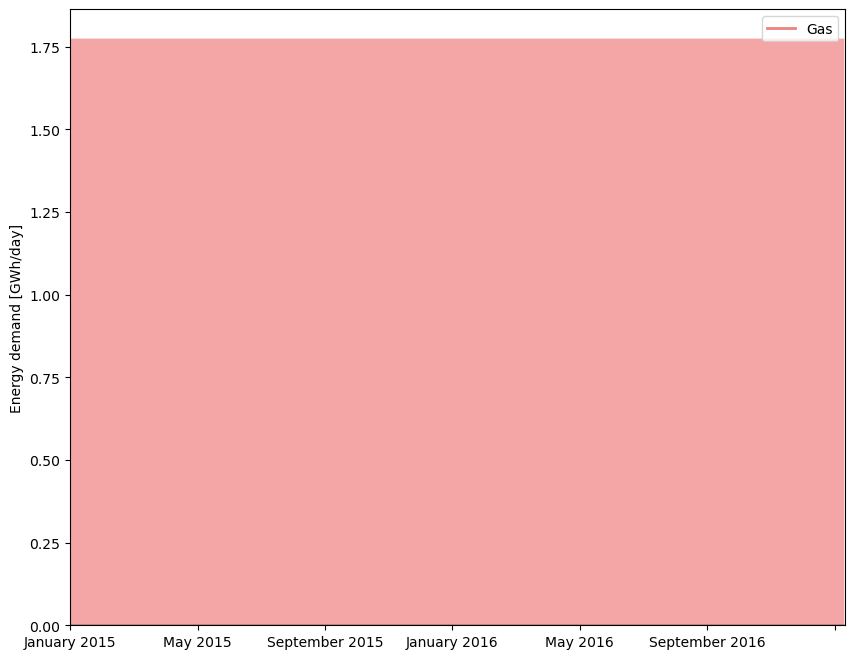

In [29]:
energy_demand()

In [30]:
import pandas as pd
import os

# Assuming these variables are defined in your notebook:
# technology_name = "Name of the Technology"
# installed_capacity = X  # Installed capacity in MW, GW, etc.
# price_per_mwh = Y  # Price per MWh in your currency

# Create a DataFrame to hold the data
data = {
    "technology": ["Wave"],
    "installed_capacity": [total_installed_capacity],
    "price_per_mwh": [price_per_mwh]
}

df = pd.DataFrame(data)

# Specify the folder where you want to save the file (ensure this folder exists)
folder_path = '../results'  # Update this path to your specific folder

# Ensure the folder exists, create if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the CSV file name with the full path
csv_file_name = os.path.join(folder_path, 'solo_tech_data.csv')

# Check if the CSV file already exists to append or create a new one
try:
    with open(csv_file_name, 'x') as f:
        df.to_csv(f, index=False)
except FileExistsError:
    with open(csv_file_name, 'a') as f:
        df.to_csv(f, header=False, index=False)

print(f"Data saved to {csv_file_name}.")

NameError: name 'technology_name' is not defined